# Thermal stability of hundreds of point mutants of a family 1 glycoside hydrolase 

Here, we are determining the thermal stability of about a hundred and fifty point mutants of BglB (model based on 2JIE). After automated mutagensis of the BglB coding sequence, protein production, and protein purification, each mutant's activity at 100 mM pNPG at pH 7.4 at a range of temperatures from 30 C to 50 C was measured using the rate of formation of the pNPG hydrolysis product p-nitrophenol. 

Data were collected into a table with the columns `well`, `rate`, and `mutant` using Google Docs and exported to CSV, which is the input file here. 

## Data input and cleanup 

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from scipy.optimize import curve_fit 
from numpy import log, exp, linspace, sqrt, diag
from sklearn.linear_model import LinearRegression
import os
import re 

df = pandas.read_csv( 'data/data_2016_03_09.csv' )
raw = len( df )
df.index = df.mutant
df.drop( 'mutant', inplace=True )
df.drop( ['WT', 'WT1'], inplace=True )
df.dropna( inplace=True ) 

with open( 'data/allowed_mutants.txt' ) as fn:
    mutants = [ i.split('.')[0].upper() for i in fn.readlines() if len( i ) > 1 ]
    
def is_good( name ):
    return name in mutants 

# this is a sanity-checking routine for "off-by-threes"
# let's just rename all the tubes
not_allowed = []
l = []
for name in df.index:
    #print name
    if is_good( name ):
        l.append( name )
    else:
        new = name[0] + str( int( re.findall( r'\d+', name )[0] ) - 3 ) + name[-1]
        if is_good( new ):
            l.append( new )
        else:
            l.append( 'drop_me' )
            not_allowed.append( name )
            
assert len( df.index ) == len( l ) # do not want to reindex wrongly! 
df.index = l
df.drop( ['drop_me'], inplace=True )

# temperature keys as CSV files in data/
temp_key = pandas.read_csv( 'data/temp_key.csv' )
temp_key.index = temp_key.Well
df['temp'] = df.well.str[0].map( temp_key.Celsius.to_dict() ) 
df.dropna( inplace=True )
pos_and_neg = len( df )
df = df[( df.rate > 0 )]
df.sample( 10 )

# diagnostics 
print 'Input has {} rates. {} will be used, {} will be dropped because of mutant name, {} because negative).'.format( raw, len( df ), raw - pos_and_neg , pos_and_neg - len( df ) ), 
print 'Samples {} were dropped because the given native residue does not match the BglB sequence and is not off by three'.format( set( not_allowed ) )

Input has 3048 rates. 2350 will be used, 48 will be dropped because of mutant name, 650 because negative). Samples set(['Q384R']) were dropped because the given native residue does not match the BglB sequence and is not off by three


## Determine protein parameters Tm and k

To determine protein parameters Tm and k (steepness of melting curve), we will fit the cleaned data to the logistic equation. To determine starting parameters for the search algorithm `curve_fit`, we'll just fit a straight line to the data using SciKit-Learn's linear regression. 

In [6]:
# logistic equation 
def f(x, x0, k): 
    return 1/(1+exp(-k*(x-x0)))

# util function to fit a mutant 
def fit( df ):
    name = df.mutant.unique()[0]
    df.rate = df.rate / df.rate.max()
    
    # linear fit 
    reg = LinearRegression()
    reg.fit( df.temp.reshape(-1, 1), df.rate )
    slope = reg.coef_[0]
    
    # try fitting to logistic eqn using approximate params from linear fit
    try:
        p0 = ( df.temp.mean(), slope )
        popt, pcov = curve_fit( f, df.temp, df.rate, p0=p0 )
        perr = sqrt( diag( pcov ) ) 
        if 30 < popt[0] < 50 and popt[1] < 0: # biological assay limits, and make sure k is the right sign
            return pandas.Series( popt, index=['tm', 'k'] )
        else:
            #iffy += [ name ]
            raise Exception( 'Warning: dropping fit for {0} because Tm of {1:2.2f} is outside range 30-50 C'.format( name, popt[0] ) )
    except Exception as e:
        print e
    
grouped = df.groupby( by='mutant' )
fits = grouped.apply( fit )
print ''
print 'Successfully fit {} of {} samples to the logistic equation'.format( len( fits.dropna() ), len( grouped ) )

Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Optimal parameters not found: Number of calls to function has reached maxfev = 600.

Successfully fit 85 of 123 samples to the logistic equation


In [7]:
fits

,tm,k
mutant,,
A195S,39.082601,-0.906304
A356A,39.888266,-1.124698
A357A,39.094581,-0.325209
A408A,39.955931,-1.260729
C167A,39.735604,-1.388447
C167Q,38.471567,-0.529354
D403A,NaN,NaN
E154D,38.699104,-0.688686
E164A,NaN,NaN


## Diagnostic plots to help determine goodness of fits

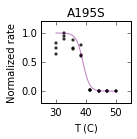

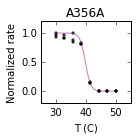

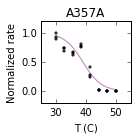

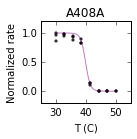

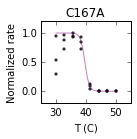

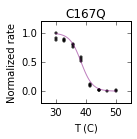

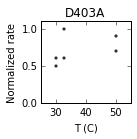

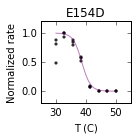

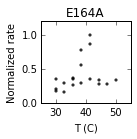

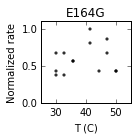

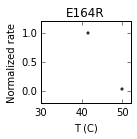

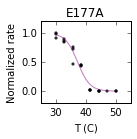

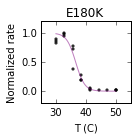

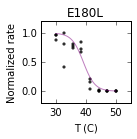

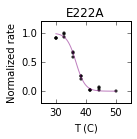

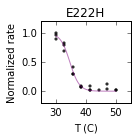

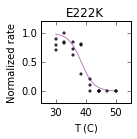

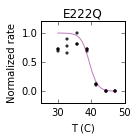

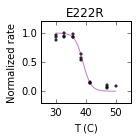

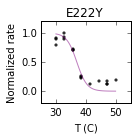

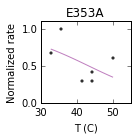

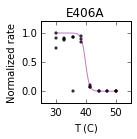

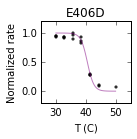

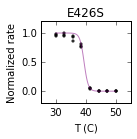

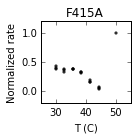

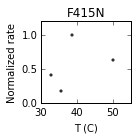

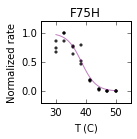

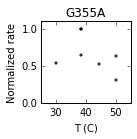

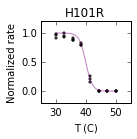

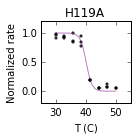

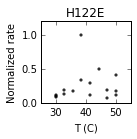

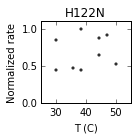

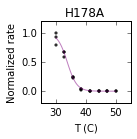

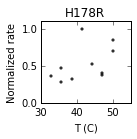

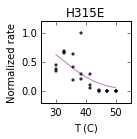

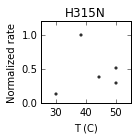

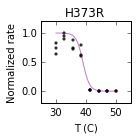

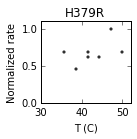

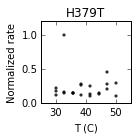

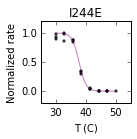

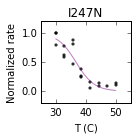

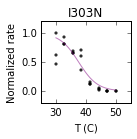

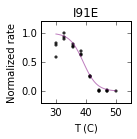

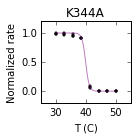

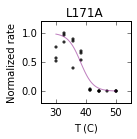

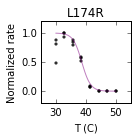

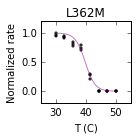

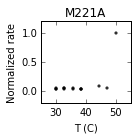

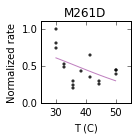

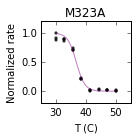

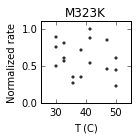

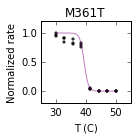

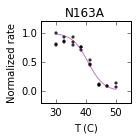

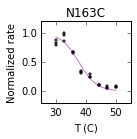

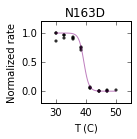

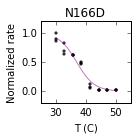

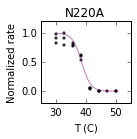

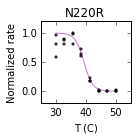

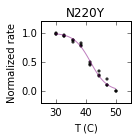

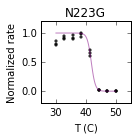

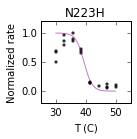

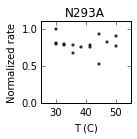

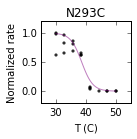

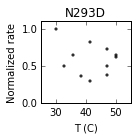

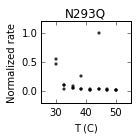

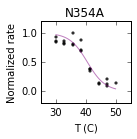

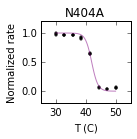

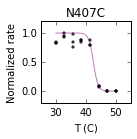

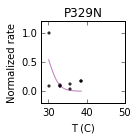

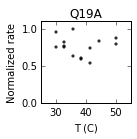

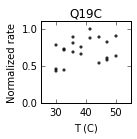

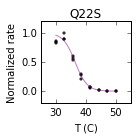

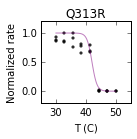

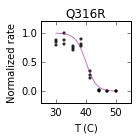

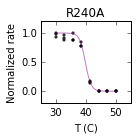

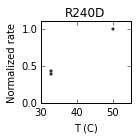

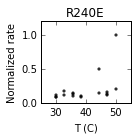

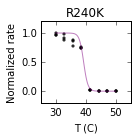

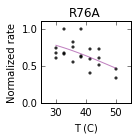

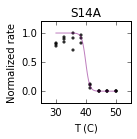

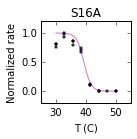

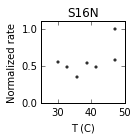

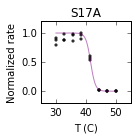

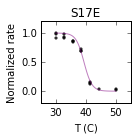

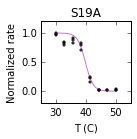

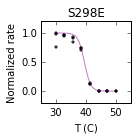

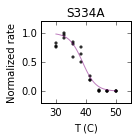

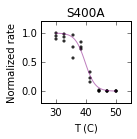

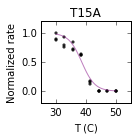

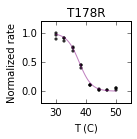

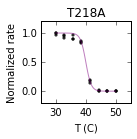

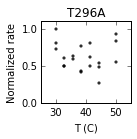

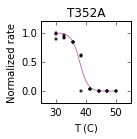

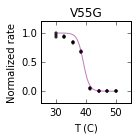

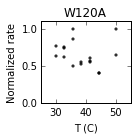

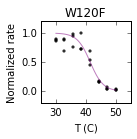

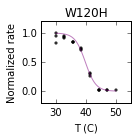

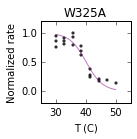

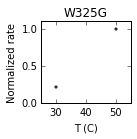

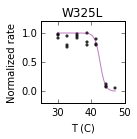

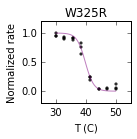

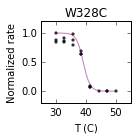

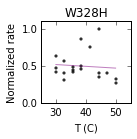

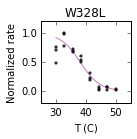

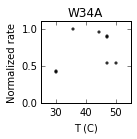

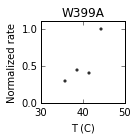

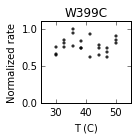

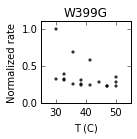

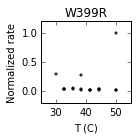

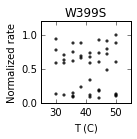

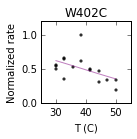

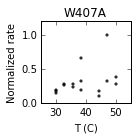

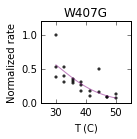

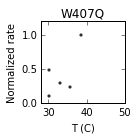

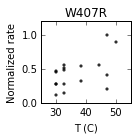

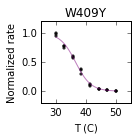

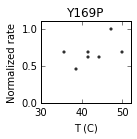

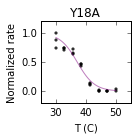

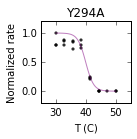

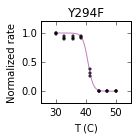

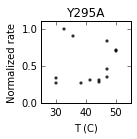

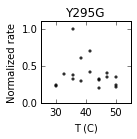

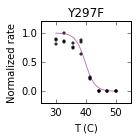

In [8]:
#!mkdir plots 
for index, df in grouped:
    name = df.mutant.unique()[0]
    rate = df.rate / df.rate.max() 
    plt.figure( figsize=(2,2) )
    plt.scatter( df.temp, rate, alpha=0.7, color='black', marker='.' )
    popt = fits.loc[ name ]
    if popt is not None:
        x_space = linspace( df.temp.min(), df.temp.max(), 100 )
        plt.plot( x_space, f( x_space, *popt ), alpha=0.5, color='purple' )
    plt.xlabel( 'T (C)' )
    plt.ylabel( 'Normalized rate')
    plt.xticks( [ 30, 40, 50 ] )
    plt.yticks( [ 0, 0.5, 1 ] )
    plt.title( name )
    plt.tight_layout()
    plt.savefig( 'plots/%s.pdf' % name, format='pdf' )
    plt.show()
    plt.close()

In [9]:
# add metadata
fits['native'] = fits.index.str[0]
fits['designed'] = fits.index.str[-1]
fits['position'] = fits.index.str[1:-1].astype( int )
fits.sample( 10 )

,tm,k,native,designed,position
mutant,,,,,
W325L,42.621159,-1.307477,W,L,325
M323K,NaN,NaN,M,K,323
W399S,NaN,NaN,W,S,399
S334A,38.959571,-0.454131,S,A,334
S16A,39.410747,-0.832755,S,A,16
E154D,38.699104,-0.688686,E,D,154
E222Y,37.041199,-0.593383,E,Y,222
E164R,NaN,NaN,E,R,164
Y295A,NaN,NaN,Y,A,295


In [10]:
# makes resfiles for DDG Rosetta app 
#!mkdir ddg/resfiles 

for ( index, series ) in fits.iterrows():
    with open( 'ddg/resfiles/{}'.format( index ), 'w' ) as fn:
        fn.write( 'NATRO\nSTART\n{} A PIKAA {}'.format( series.position, series.designed ) )

In [11]:
%%bash 
# this will run the Rosetta app `ddg_monomer` on all the mutants in `fits`, above

#ls ddg/resfiles > ddg/list
#NUM=$( wc -l ddg/list | cut -d' ' -f1 )
#cd ddg && sbatch --array=1-${NUM} sub.sh 

## Comparison between Rosetta `ddg_monomer` app and experimental results

In [12]:
! ( head -1 ddg/ddg_predictions.out && grep -v desc ddg/ddg_predictions.out ) > ddg/readable_output

In [13]:
preds = pandas.read_csv( 'ddg/readable_output', sep='\s+' )
preds.index = preds.description.values
joined = preds.join( fits )
joined.sample( 10 )

,ddG:,description,total,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_elec,pro_close,hbond_sr_bb,...,fa_dun,p_aa_pp,ref,chainbreak,res_type_constraint,tm,k,native,designed,position
W407A,ddG:,W407A,6.459,19.215,-2.881,-7.476,-0.036,1.627,0.040,-0.404,...,-3.701,-0.636,-0.336,0,0,NaN,NaN,W,A,407
W399G,ddG:,W399G,10.651,24.233,-5.874,-14.929,-0.032,4.840,0.058,0.211,...,-0.525,0.894,-0.789,0,0,NaN,NaN,W,G,399
N354A,ddG:,N354A,2.256,6.151,0.621,-5.283,-0.005,-0.662,0.020,0.187,...,-0.830,0.275,1.535,0,0,40.557793,-0.335794,N,A,354
W407G,ddG:,W407G,5.565,27.883,-5.354,-14.514,-0.025,1.826,0.002,-0.257,...,-2.541,-1.575,-0.789,0,0,31.738916,-0.140748,W,G,407
Y295G,ddG:,Y295G,12.340,12.511,-1.216,-7.253,-0.001,4.241,0.053,0.135,...,-0.742,1.291,0.009,0,0,NaN,NaN,Y,G,295
N293C,ddG:,N293C,1.167,2.506,1.527,-5.248,-0.001,1.507,0.064,-0.027,...,-3.491,-0.026,1.297,0,0,38.667392,-0.536787,N,C,293
R297F,ddG:,R297F,2.024,-0.817,-2.077,-4.316,0.049,1.779,0.089,0.055,...,2.782,-0.380,0.580,0,0,NaN,NaN,NaN,NaN,NaN
P329N,ddG:,P329N,3.537,2.321,-0.903,-2.334,-0.019,3.267,-0.124,-0.026,...,-0.535,0.202,-0.723,0,0,30.250264,-0.791904,P,N,329
F415A,ddG:,F415A,4.108,12.428,-2.265,-4.118,-0.026,0.293,0.007,-0.047,...,-2.270,-0.016,0.162,0,0,NaN,NaN,F,A,415
E361T,ddG:,E361T,-0.819,-1.029,0.988,2.588,0.000,0.198,0.007,-0.361,...,-5.284,0.062,1.718,0,0,NaN,NaN,NaN,NaN,NaN


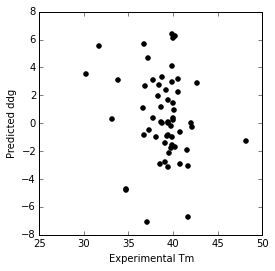

In [14]:
plt.figure( figsize=( 4, 4 ) )
plt.scatter( joined.tm, joined.total, color='k' )
#plt.plot( ( joined.tm.min(), joined.tm.max() ), ( joined.total.max() , joined.total.min() ), color='red', alpha=0.4 ) #perfect correlation
plt.xlabel( 'Experimental Tm' )
plt.ylabel( 'Predicted ddg' )

total float64


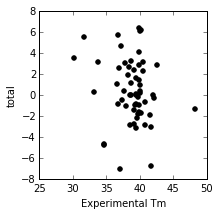

fa_atr float64


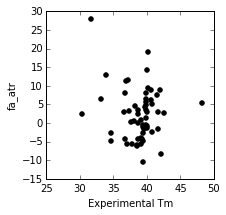

fa_rep float64


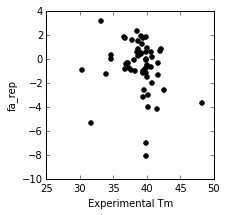

fa_sol float64


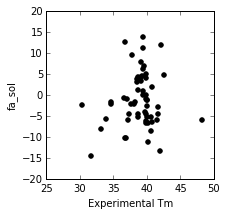

fa_intra_rep float64


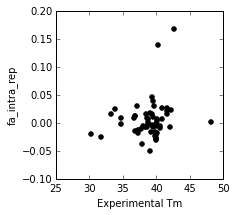

fa_elec float64


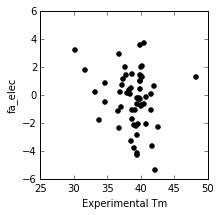

pro_close float64


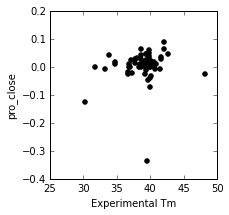

hbond_sr_bb float64


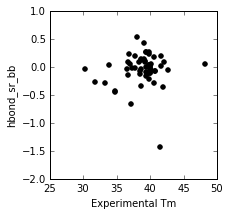

hbond_lr_bb float64


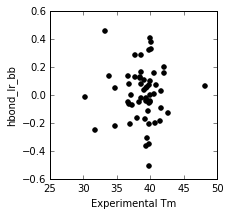

hbond_bb_sc float64


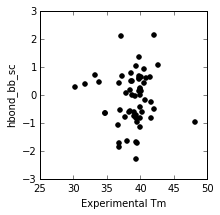

hbond_sc float64


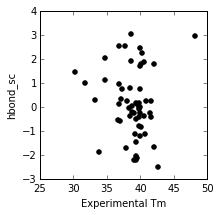

dslf_fa13 float64


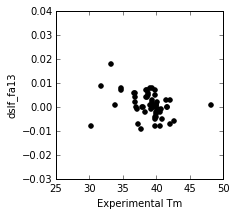

coordinate_constraint float64


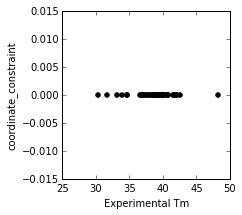

angle_constraint float64


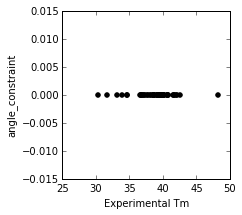

dihedral_constraint float64


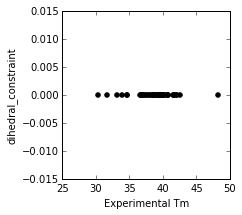

rama float64


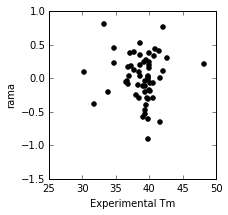

omega float64


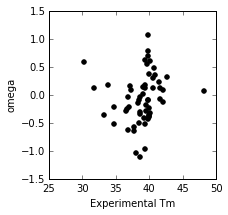

fa_dun float64


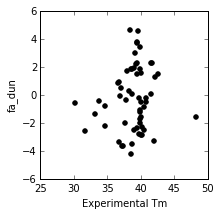

p_aa_pp float64


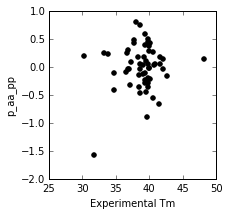

ref float64


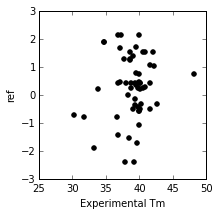

chainbreak float64


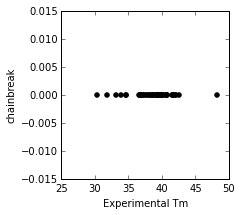

res_type_constraint float64


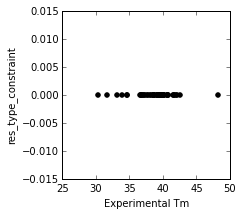

position float64


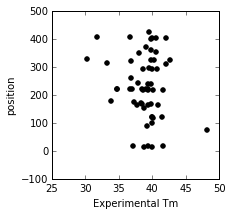

In [15]:
for col, dtype in zip( joined.columns, joined.dtypes ):
    if str( dtype ) == 'float64' and str( col ) not in ['tm', 'k']:
        print col, dtype
        plt.figure( figsize=( 3, 3 ) )
        plt.scatter( joined.tm, joined[col], color='k' )
        #plt.plot( ( joined.tm.min(), joined.tm.max() ), ( joined.total.max() , joined.total.min() ), color='red', alpha=0.4 ) #perfect correlation
        plt.xlabel( 'Experimental Tm' )
        plt.ylabel( col )
        plt.show()

So nothing really correlates, even predicted $\Delta G$ of folding. Bummmer. 

# Rosetta plus machine learning [outperforms `ddg_monomer`?]

Instead, let's make models of the mutants using `EnzRepackMinimize` and then try to use machine learning to get better correlation.

In [16]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import BaggingRegressor
from sklearn.grid_search import GridSearchCV
from glob import glob 

dfs = [ pandas.read_csv( i, sep=r'\s+' ) for i in glob( 'enzdes/out/*sc' ) ]
df = pandas.concat( dfs )
print len( df ), 'models'
df.sample( 10 )

12863 models


,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,description
0,-631.28,223.88,-71.55,0.01,0.70,0.69,145,437,147,0.77,...,446,-5.69,0.90,-3.49,0.00,-11.39,0.90,7,1,bglb_163ALA_73_0001
0,-181.11,629.05,-71.77,0.01,0.69,0.70,144,440,144,0.62,...,446,-5.35,0.90,-3.25,0.00,-10.70,0.90,7,1,bglb_101ARG_74_0001
0,-624.22,222.96,-70.02,0.01,0.69,0.68,144,436,148,1.07,...,446,-4.33,0.78,-2.20,0.01,-8.66,0.90,5,1,bglb_407ALA_83_0001
0,-625.57,226.28,-71.22,0.01,0.70,0.68,147,438,150,0.82,...,446,-5.46,0.83,-3.34,0.00,-10.92,0.93,7,1,bglb_222GLN_19_0001
0,-628.11,226.65,-70.79,0.00,0.69,0.70,148,436,149,0.77,...,446,-5.71,0.86,-3.21,0.00,-11.42,0.91,7,1,bglb_220HIS_12_0001
0,-626.95,224.46,-71.65,0.00,0.70,0.68,147,440,148,0.60,...,446,-5.18,1.07,-3.44,0.00,-10.35,0.89,7,1,bglb_178ALA_58_0001
0,-623.99,225.78,-72.22,0.00,0.70,0.70,142,439,149,0.77,...,446,-5.33,0.86,-3.91,0.00,-10.65,0.89,8,1,bglb_325HIS_79_0001
0,-627.43,225.51,-72.69,0.00,0.70,0.70,143,438,149,0.90,...,446,-5.88,0.91,-3.94,0.00,-11.75,0.90,8,1,bglb_404ALA_33_0001
0,-629.50,219.65,-68.98,0.00,0.70,0.68,149,436,147,0.99,...,446,-4.00,0.90,-2.31,0.00,-7.99,0.90,6,1,bglb_120ALA_40_0001
0,-628.85,221.00,-72.21,0.01,0.70,0.69,149,439,148,0.88,...,446,-5.38,0.77,-3.39,0.01,-10.76,0.90,7,1,bglb_407LYS_19_0001


In [17]:
from Bio.SeqUtils import IUPACData
import screed

for record in screed.open( 'data/bglb.pep' ):
    seq = record.sequence

# blarg, we have to reindex the DataFrame because of how I named the Rosetta output
l = []
for i in df.description:
    j = i.split( '_' )[1]
    pos = j[:-3]
    native = seq[ int(pos) - 1 ].upper()
    designed = IUPACData.protein_letters_3to1[ j[-3:].capitalize() ] # good god why
    l.append( '{}{}{}'.format( native, pos, designed ) )
df['name'] = l

In [18]:
df.head( 20 )

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,description,name
0,-621.52,227.68,-71.56,0.01,0.70,0.68,145,438,150,0.67,...,-5.45,0.95,-3.62,0.00,-10.91,0.90,8,1,bglb_219ALA_98_0001,L219A
0,-625.44,223.92,-74.89,0.01,0.69,0.69,140,439,148,0.67,...,-6.42,0.77,-4.23,0.00,-12.84,0.91,8,1,bglb_34ALA_59_0001,W34A
0,-623.50,227.11,-71.43,0.00,0.71,0.69,148,437,150,0.99,...,-5.75,0.89,-4.01,0.00,-11.49,0.93,8,1,bglb_240LYS_15_0001,R240K
0,-612.03,225.36,-66.07,0.00,0.70,0.68,148,433,146,0.99,...,-3.54,1.09,-1.78,0.00,-7.08,0.91,4,2,bglb_407ALA_62_0001,W407A
0,-620.22,226.81,-69.18,0.00,0.69,0.69,149,435,147,0.65,...,-5.06,0.85,-3.14,0.00,-10.12,0.91,7,1,bglb_407TYR_24_0001,W407Y
0,-626.34,225.29,-73.66,0.01,0.68,0.67,144,439,147,0.65,...,-5.93,0.89,-4.03,0.00,-11.85,0.90,8,1,bglb_72ALA_49_0001,F72A
0,-630.24,225.53,-73.43,0.00,0.71,0.70,137,440,149,0.72,...,-5.96,0.93,-3.98,0.00,-11.92,0.90,8,1,bglb_404ALA_44_0001,N404A
0,-630.54,225.68,-74.10,0.01,0.70,0.70,141,439,151,0.77,...,-5.96,0.92,-4.07,0.01,-11.92,0.91,8,1,bglb_52GLY_55_0001,V52G
0,-629.84,224.86,-72.00,0.01,0.71,0.70,143,439,149,0.75,...,-5.18,1.09,-3.47,0.00,-10.36,0.90,7,1,bglb_315ASN_66_0001,H315N
0,-555.96,277.82,-70.43,0.00,0.70,0.69,154,433,143,0.77,...,-5.70,1.12,-3.98,0.00,-11.41,0.90,8,1,bglb_32LEU_100_0001,S32L


In [19]:
# get lowest 10% energy by total_score 
def low_10( df ):
    return df.sort( 'total_score' ).head( 10 )

df = df.groupby( 'name' ).apply( low_10 )
df.head( 20 )

total_score   fa_rep  hbond_sc  all_cst  tot_pstat_pm  \
name                                                             
A192S 0      -634.39   222.81    -73.18     0.01          0.69   
      0      -633.78   223.71    -74.49     0.01          0.71   
      0      -633.67   225.06    -73.63     0.01          0.71   
      0      -633.65   223.75    -73.68     0.00          0.70   
      0      -633.53   223.72    -74.34     0.00          0.70   
      0      -632.89   224.81    -73.80     0.01          0.68   
      0      -632.73   223.95    -74.97     0.01          0.70   
      0      -632.35   224.53    -74.38     0.01          0.68   
      0      -631.77   226.00    -73.49     0.00          0.70   
      0      -631.41   224.67    -76.32     0.01          0.70   
A227W 0      5150.70  5996.03    -73.48     0.00          0.69   
      0      5150.79  5996.62    -73.39     0.00          0.69   
      0      5151.43  5997.01    -72.07     0.00          0.70   
      0      5152.47  5997.75    -73.01     0.00          0.69   
      0      5152.83  5997.39    -73.05     0.00          0.71   
      0      5152.85  5997.00    -73.13     0.00          0.69   
      0      5153.26  5996.45    -74.42     0.00          0.69   
      0      5153.54  5997.27    -72.26     0.00          0.69   
      0      5153.68  5997.56    -72.55     0.00          0.70   
      0      5154.22  5997.39    -72.74     0.01          0.71   

         tot_nlpstat_pm  tot_burunsat_pm  tot_hbond_pm  tot_NLconts_pm  \
name                                                                     
A192S 0            0.68              141           438             148   
      0            0.69              142           441             150   
      0            0.69              146           438             150   
      0            0.70              145           439             149   
      0            0.69              142           441             153   
      0            0.69              143           441             147   
      0            0.69              138           441             151   
      0            0.70              142           440             151   
      0            0.70              141           441             149   
      0            0.69              141           439             152   
A227W 0            0.69              141           440             150   
      0            0.69              144           440             151   
      0            0.70              147           438             148   
      0            0.70              146           439             150   
      0            0.70              143           438             149   
      0            0.68              144           440             150   
      0            0.70              146           439             149   
      0            0.68              146           438             150   
      0            0.69              146           439             150   
      0            0.70              145           440             152   

         tot_nlsurfaceE_pm  ...    SR_5_total_score  SR_5_fa_rep  \
name                        ...                                    
A192S 0               0.65  ...               -5.78         0.86   
      0               0.82  ...               -5.80         1.00   
      0               0.82  ...               -5.33         0.94   
      0               0.82  ...               -5.42         0.88   
      0               0.58  ...               -5.87         0.93   
      0               0.60  ...               -5.35         0.91   
      0               0.82  ...               -5.82         0.93   
      0               0.65  ...               -5.75         0.99   
      0               0.69  ...               -5.42         0.81   
      0               0.65  ...               -6.13         0.87   
A227W 0               0.84  ...               -6.01         0.90   
      0               0.89  ...            

In [20]:
# reindex and join with experimental data 
df.index = df.name 
joined = df.join( fits )
joined.sample( 10 )

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,description,name,tm,k,native,designed,position
W325C,-632.10,222.21,-72.42,0.01,0.69,0.69,142,437,146,0.75,...,0.86,8,1,bglb_325CYS_32_0001,W325C,NaN,NaN,NaN,NaN,NaN
W325H,-630.45,223.59,-72.78,0.00,0.71,0.70,143,441,146,0.82,...,0.89,8,1,bglb_325HIS_0_0001,W325H,NaN,NaN,NaN,NaN,NaN
E222Q,-631.19,224.31,-73.84,0.00,0.69,0.69,141,442,150,0.84,...,0.91,8,1,bglb_222GLN_7_0001,E222Q,39.421645,-0.815422,E,Q,222
N220H,-634.01,224.87,-71.04,0.01,0.69,0.69,147,438,149,0.77,...,0.91,7,1,bglb_220HIS_27_0001,N220H,NaN,NaN,NaN,NaN,NaN
N163A,-633.37,223.56,-71.16,0.00,0.71,0.68,137,437,147,0.77,...,0.90,7,1,bglb_163ALA_20_0001,N163A,40.801930,-0.377449,N,A,163
A227W,5154.22,5997.39,-72.74,0.01,0.71,0.70,145,440,152,0.89,...,0.90,8,1,bglb_227TRP_31_0001,A227W,NaN,NaN,NaN,NaN,NaN
W120A,-632.86,219.62,-73.63,0.01,0.68,0.68,144,441,147,0.99,...,0.90,8,1,bglb_120ALA_6_0001,W120A,NaN,NaN,W,A,120
W325E,-633.17,223.40,-74.41,0.00,0.70,0.70,142,443,147,0.58,...,0.87,8,0,bglb_325GLU_77_0001,W325E,NaN,NaN,NaN,NaN,NaN
D121F,-627.16,228.83,-71.67,0.00,0.70,0.69,149,437,152,0.75,...,0.91,6,1,bglb_121PHE_20_0001,D121F,NaN,NaN,NaN,NaN,NaN
T218A,-632.99,222.34,-71.21,0.00,0.69,0.70,138,440,148,0.67,...,0.91,8,1,bglb_218ALA_90_0001,T218A,40.045653,-1.122531,T,A,218


In [ ]:
# diagnostics and droping NaN values 
print len( joined )
joined.dropna( inplace = True )
print len( joined ), 'models'

# clean up data for sklearn
x_cols = [ u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
       u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'tot_total_pos_charges', u'tot_total_neg_charges', u'tot_seq_recovery',
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_all_cst', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', u'SR_5_all_cst',
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm', ]

X = joined[ x_cols ]
y = joined[ 'tm' ]

1250
460 models


Now we actually fit the data to the model

Number of models 1
PCC=(0.52514131969539968, 5.7517792467570399e-34)


/home/carlin/bin/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


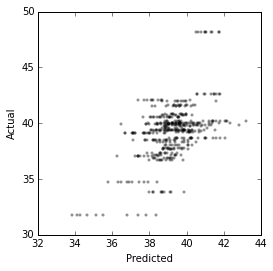

In [ ]:
params = { 'l1_ratio': [.1, .5, .7, .9, .95, .99, 1] }

from sklearn.cross_validation import StratifiedKFold
from scipy.stats.stats import pearsonr

for i in [ 1, 10, 100, 1000 ]:
    #skf = StratifiedKFold( y, 10 )
    net = ElasticNetCV( cv=10 )
    grid = GridSearchCV( net, params )
    bag = BaggingRegressor( grid, n_estimators=i )
    bag.fit( X, y )

    preds = bag.predict( X )
    print 'Number of models', i 
    print 'PCC={}'.format( pearsonr( preds, y ) )

    plt.figure( figsize=(4,4) )
    plt.scatter( preds, y, alpha=0.3, marker='.', color='k' )
    plt.xlabel( 'Predicted' )
    plt.ylabel( 'Actual' )
    plt.show()
    
    weights = pandas.DataFrame( zip( X.columns, bag.estimators_[0].best_estimator_.coef_ ), columns=['feature', 'weight'] )
    print weights.sort( 'weight' )[0:11]

So that's fairly underwhelming. Let's try something else. 

## Structures minimized with `ddg_monomer` scored using EnzDes-style metrics 

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import BaggingRegressor
from sklearn.grid_search import GridSearchCV
from glob import glob 


df = pandas.read_csv( 'enzdes_score_ddg/out/score.sc', sep='\s+' )
print len( df ), 'models'
df.sample( 10 )

# # reindex and join with experimental data 
# df.index = df.name 
# joined = df.join( fits )
# joined.sample( 10 )

# # diagnostics and droping NaN values 
# print len( joined )
# joined.dropna( inplace = True )
# print len( joined ), 'models'

# # clean up data for sklearn
# x_cols = [ u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
#        u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
#        u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
#        u'tot_total_pos_charges', u'tot_total_neg_charges', u'tot_seq_recovery',
#        u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
#        u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
#        u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
#        u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_all_cst', u'SR_2_hbond_pm',
#        u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
#        u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
#        u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
#        u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
#        u'SR_4_hbond_sc', u'SR_4_hbond_pm',
#        u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
#        u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', u'SR_5_all_cst',
#        u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
#        u'SR_5_burunsat_pm', ]

# X = joined[ x_cols ]
# y = joined[ 'tm' ]

# params = { 'l1_ratio': [.1, .5, .7, .9, .95, .99, 1] }

# from sklearn.cross_validation import StratifiedKFold
# from scipy.stats.stats import pearsonr

# for i in [ 1, 10, 100, 1000 ]:
#     #skf = StratifiedKFold( y, 10 )
#     net = ElasticNetCV( cv=10 )
#     grid = GridSearchCV( net, params )
#     bag = BaggingRegressor( grid, n_estimators=i )
#     bag.fit( X, y )

#     preds = bag.predict( X )
#     print 'Number of models', i 
#     print 'PCC={}'.format( pearsonr( preds, y ) )

#     plt.figure( figsize=(4,4) )
#     plt.scatter( preds, y, alpha=0.3, marker='.', color='k' )
#     plt.xlabel( 'Predicted' )
#     plt.ylabel( 'Actual' )
#     plt.show()
    
#     weights = pandas.DataFrame( zip( X.columns, bag.estimators_[0].best_estimator_.coef_ ), columns=['feature', 'weight'] )
#     print weights.sort( 'weight' )[0:11]